# CS 39AA - Notebook H: Airline Tweets using Word Embeddings

We've started talking about word embeddings; what they are as well as how we both create and use them. We'll now see what it looks like to load and use pre-made embeddings on the Airline Tweet dataset. 

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/sgeinitz/cs39aa_notebooks/blob/main/nb_C_airline_tweets_take2.ipynb)

In [521]:
import torch
import random
import pandas as pd
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
import seaborn as sns

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchmetrics.functional import pairwise_cosine_similarity
from tqdm import notebook

In [522]:
import torchtext as text
vec = text.vocab.GloVe(name='6B', dim=50)

Load the airline tweets and prepare to load embeddings for each tweet. 

In [523]:
examples = ['annoy', 'annoyed', 'disappointed', 'sad', 'happy', 'pilot', 'crew', 'flight']#, 'suitcase', 'backpack', 'carryon']
embeddings = vec.get_vecs_by_tokens(examples, lower_case_backup=True)
embeddings

tensor([[ 2.3457e-01, -4.7683e-01,  6.3459e-01, -3.6475e-01, -2.1981e-01,
         -4.5539e-01,  7.0779e-01,  1.0140e+00, -9.1157e-01,  4.6997e-01,
         -2.2969e-01,  6.6490e-01,  7.6746e-01, -1.0760e-01,  3.6551e-03,
          8.9326e-01, -9.5184e-02, -5.2423e-02,  8.8386e-01, -4.9152e-01,
         -3.5541e-01, -1.9993e-01,  1.9838e-02,  8.1985e-01,  1.0315e+00,
         -6.9975e-01, -2.9327e-01, -4.7181e-01,  8.7062e-01, -1.0971e+00,
         -6.3421e-01,  1.1884e+00, -3.3743e-02, -3.8841e-01, -4.6839e-01,
          8.8104e-02, -1.6746e-01, -4.0789e-01, -3.7836e-01, -1.4252e-01,
          2.0980e-01,  1.7340e-01,  1.9545e-01,  6.8907e-01,  1.0228e+00,
          2.3531e-01,  1.9601e-01, -2.6078e-01, -8.8978e-02,  5.7906e-01],
        [ 1.9271e-01, -9.8134e-01, -1.9098e-01, -6.1861e-01,  2.4468e-02,
         -2.0539e-01, -2.0984e-01,  1.0406e+00, -1.0876e+00,  1.1150e-01,
          2.6504e-01,  2.1416e-01,  5.5952e-02, -1.3927e-01,  5.4169e-01,
          5.0256e-01, -2.6933e-01,  3

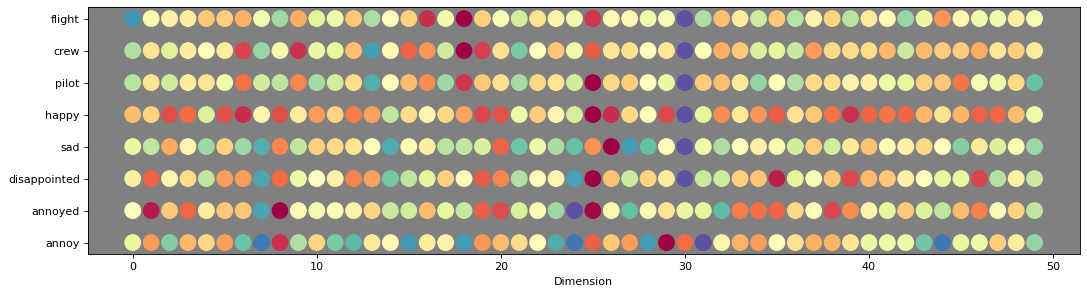

In [524]:
def compare_words_with_colors(vecs, wds):
    wdsr = wds[:]
    wdsr.reverse()
        
    dim = len(vecs[0])
    
    fig = plt.figure(num=None, figsize=(16, 4), dpi=80, facecolor='w', edgecolor='k')
    ax = fig.add_subplot(111)
    ax.set_facecolor('gray')
    
    for i,v in enumerate(vecs):
        ax.scatter(range(dim),[i]*dim, c=vecs[i], cmap='Spectral', s=200)
    
    #plt.xticks(range(n), [i+1 for i in range(n)])
    plt.xlabel('Dimension')
    plt.yticks(range(len(wds)), wds)
    
    plt.show()

compare_words_with_colors(embeddings, examples)
#examples.reverse()

In [525]:
similarities = pairwise_cosine_similarity(embeddings, zero_diagonal=False)
distances = 1 - similarities 
distances

pairwise_top = pd.DataFrame(
    distances,
    columns = examples,
    index = examples
)

distances
#similarities


tensor([[ 0.0000e+00,  4.3455e-01,  7.1622e-01,  7.6653e-01,  7.2499e-01,
          1.1374e+00,  1.1141e+00,  1.1263e+00],
        [ 4.3455e-01,  1.1921e-07,  2.5124e-01,  5.1642e-01,  4.5671e-01,
          8.4883e-01,  8.7239e-01,  9.3474e-01],
        [ 7.1622e-01,  2.5124e-01,  5.9605e-08,  4.2236e-01,  2.3252e-01,
          7.4722e-01,  6.9937e-01,  7.9178e-01],
        [ 7.6653e-01,  5.1642e-01,  4.2236e-01, -1.1921e-07,  3.1094e-01,
          8.3679e-01,  8.0400e-01,  8.5987e-01],
        [ 7.2499e-01,  4.5671e-01,  2.3252e-01,  3.1094e-01,  0.0000e+00,
          6.6121e-01,  5.9392e-01,  6.9901e-01],
        [ 1.1374e+00,  8.4883e-01,  7.4722e-01,  8.3679e-01,  6.6121e-01,
          0.0000e+00,  1.4877e-01,  2.1097e-01],
        [ 1.1141e+00,  8.7239e-01,  6.9937e-01,  8.0400e-01,  5.9392e-01,
          1.4877e-01,  0.0000e+00,  2.3664e-01],
        [ 1.1263e+00,  9.3474e-01,  7.9178e-01,  8.5987e-01,  6.9901e-01,
          2.1097e-01,  2.3664e-01,  1.1921e-07]])

<AxesSubplot:>

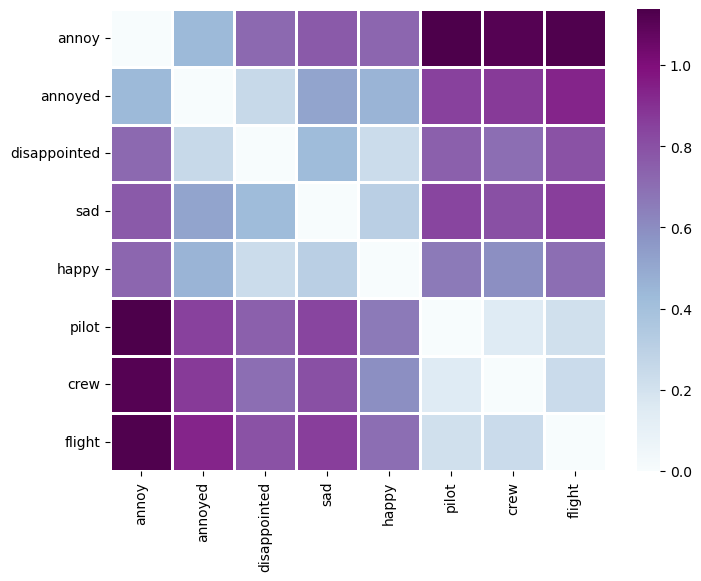

In [526]:
plt.figure(figsize=(8,6))
#sns.color_palette("viridis", as_cmap=True)
sns.color_palette("mako", as_cmap=True)
sns.heatmap(
    pairwise_top,
    cmap='BuPu', #'OrRd',
    linewidth=1
)

In [527]:
data_URL = 'https://raw.githubusercontent.com/sgeinitz/cs39aa_notebooks/main/data/trainA.csv'
df = pd.read_csv(data_URL)
print(f"df.shape: {df.shape}")
pd.set_option("display.max_colwidth", 240)
df.head(10)

df.shape: (10000, 2)


,sentiment,text
0,positive,@JetBlue @JayVig I like the inflight snacks! I'm flying with you guys on 2/28! #JVMChat
1,positive,@VirginAmerica thanks guys! Sweet route over the Rockies #airplanemodewason
2,negative,@USAirways Your exchange/credit policies are worthless and shadier than the White House. Dissatisfied to the nines right now.
3,negative,@USAirways but in the meantime I'll be sleeping on a park bench on dadeland st. Thanks guys!
4,negative,@VirginAmerica hold times at call center are a bit much
5,negative,@USAirways not moving we are in the tarmac delayed for some unknown reason. I'll keep you posted
6,neutral,"@JetBlue What about if I booked it through Orbitz? My email is correct, but there's a middle party."
7,negative,@united 2nd flight also delayed no pilots! But they boarded is so we can just sit here! #scheduling
8,negative,".@AmericanAir after 50 minutes on hold, and another 30 minutes on the call yes. Going to be pushing it to get to the airport on time now"
9,positive,@JetBlue flight 117. proud to fly Jet Blue!


Recall that about 2/3 of the data have negative labels, and that the remaining labels are roughly split between positive and neutral (slightly more neutral than positive). 

In [528]:
random.seed(42) 
indices = list(range(len(df)))
random.shuffle(indices)

df_test = df.iloc[indices[9000:],]
df = df.iloc[indices[:9000],]

In [529]:
df.sentiment.value_counts(normalize=False)

negative    5868
neutral     1726
positive    1406
Name: sentiment, dtype: int64

Let's start with the nltk TweetTokenizer, which will split the text into separate words and characters based on common Twitter conventions. 

In [530]:
import torchtext
from torchtext.data import get_tokenizer
tokenizer = get_tokenizer("basic_english") # "basic_english"   "subword" uses revtok module (but does not work with GLoVE)
df['tokens_raw'] = df['text'].apply(lambda x: tokenizer(x.lower()))
df.head()

,sentiment,text,tokens_raw
3771,neutral,@JetBlue Come on and provide service from Destin- Fort Walton Beach Airport,"[@jetblue, come, on, and, provide, service, from, destin-, fort, walton, beach, airport]"
6672,positive,@JetBlue u the real MVP http://t.co/jWL26G6lRw,"[@jetblue, u, the, real, mvp, http, //t, ., co/jwl26g6lrw]"
7261,negative,"@SouthwestAir My brother &amp; his girlfriend’s flight Cancelled Flightled 3 times, now leaving 72 hours Late Flight and dropping letter grades at school. Help?","[@southwestair, my, brother, &amp, his, girlfriend’s, flight, cancelled, flightled, 3, times, ,, now, leaving, 72, hours, late, flight, and, dropping, letter, grades, at, school, ., help, ?]"
760,neutral,@AmericanAir More or less - after a night in a party hotel - no sleep and a 5:30 am rebook- on our way back to PHL http://t.co/4G0K0z2rei,"[@americanair, more, or, less, -, after, a, night, in, a, party, hotel, -, no, sleep, and, a, 5, 30, am, rebook-, on, our, way, back, to, phl, http, //t, ., co/4g0k0z2rei]"
3779,neutral,@JetBlue marks 15th birthday with 'Blumanity' paint job - @Dallas_News (blog) http://t.co/lFGR0Nifut,"[@jetblue, marks, 15th, birthday, with, ', blumanity, ', paint, job, -, @dallas_news, (, blog, ), http, //t, ., co/lfgr0nifut]"


We can now look at the emebedding for each individual token in a single tweet. Notice that when a token does not exist in GloVE that it is assigned all zeros. 

<AxesSubplot:>

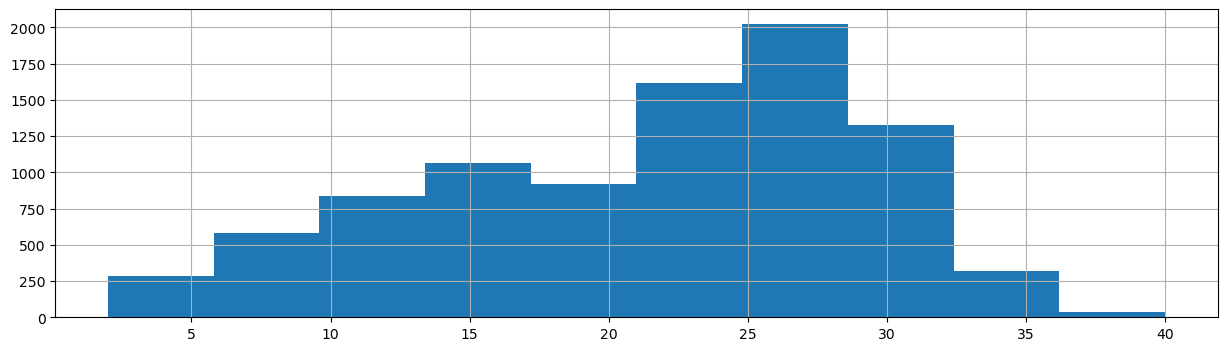

In [531]:
df['tweet_length'] = df['tokens_raw'].apply(lambda x: len(x))
df['tweet_length'].hist()

In [532]:
tweet_i= 65
tweet_embeddings = vec.get_vecs_by_tokens(df['tokens_raw'][tweet_i], lower_case_backup=True)
print(f"sentiment of this tweet: {df['sentiment'][tweet_i]}")
print(f"tweet_embeddings.shape = {tweet_embeddings.shape}")
for i in range(df['tweet_length'][tweet_i]):
    print(f"    token, '{df['tokens_raw'][tweet_i][i]}' (at pos {i:2.0f}) has tweet_embeddings[:5] = {tweet_embeddings[i][:5]}")

sentiment of this tweet: negative
tweet_embeddings.shape = torch.Size([15, 50])
    token, '@usairways' (at pos  0) has tweet_embeddings[:5] = tensor([0., 0., 0., 0., 0.])
    token, 'no' (at pos  1) has tweet_embeddings[:5] = tensor([ 0.3496,  0.4015, -0.0126,  0.1374,  0.4008])
    token, 'my' (at pos  2) has tweet_embeddings[:5] = tensor([-0.2728,  0.7752, -0.1018, -0.9166,  0.9048])
    token, 'flight' (at pos  3) has tweet_embeddings[:5] = tensor([ 1.7306,  0.2840, -0.0406, -0.0874, -0.4819])
    token, 'plans' (at pos  4) has tweet_embeddings[:5] = tensor([ 1.3427, -0.0681,  0.5598,  0.2806, -0.5117])
    token, 'have' (at pos  5) has tweet_embeddings[:5] = tensor([ 0.9491, -0.3497,  0.4812, -0.1931, -0.0088])
    token, 'been' (at pos  6) has tweet_embeddings[:5] = tensor([ 0.9288, -0.7246,  0.0681, -0.3816, -0.0387])
    token, 'delayed' (at pos  7) has tweet_embeddings[:5] = tensor([ 1.0818, -0.3236,  0.0523,  0.2775, -1.1769])
    token, 'until' (at pos  8) has tweet_embeddin

In [533]:
tweet_embeddings.shape

torch.Size([15, 50])

Before we continue we must decide what a good length will be for a max-length of the number of tokens to keep. Let's look at a histogram of the lenghts of each tweet (where length equals the number of raw tokens).

In [534]:
def meanTweetEmbeddings(raw_tokens):
    embeddings = vec.get_vecs_by_tokens(raw_tokens, lower_case_backup=True)
    n_embs = 0
    emb_sum = torch.zeros((embeddings.shape[1]))
    for i in range(min(embeddings.shape[0], 35)):
        if embeddings[i].abs().sum() > 0:
            n_embs += 1
            emb_sum += embeddings[i]
    if n_embs > 0:
        emb_avg = emb_sum / n_embs
    else:
        emb_avg = torch.zeros((embeddings.shape[1]))
    if np.any(np.isnan(emb_avg.numpy())):
        print(f"exists an nan: {emb_sum}")
    return emb_avg

#X_int = df['tokens_raw'].apply(lambda x: meanTweetEmbeddings(x)).values
#X_int[:5]

In [535]:
# an alternative to the above is to stack the first k tokens in a tweet together so that we keep the 
# original embeddings, the disadvantage being that we are dropping all the tokens after the kth one
def stack_k_TweetEmbeddings(raw_tokens, k = 25):
    embeddings = vec.get_vecs_by_tokens(raw_tokens, lower_case_backup=True)
    #n_embs = 0
    emb_stacked = torch.zeros((k, embeddings.shape[1]))
    j = 0
    for i in range(min(embeddings.shape[0], k)):
        if embeddings[i].abs().sum() <= 1e-3:
            continue
        else:
            emb_stacked[j] = embeddings[i]
            j += 1
    if np.any(np.isnan(emb_stacked.numpy())):
        print(f"exists an nan: {emb_stacked}")
    return emb_stacked.flatten()

X_int = df['tokens_raw'].apply(lambda x: stack_k_TweetEmbeddings(x)).values
#X_int[:5]

In [536]:
X = torch.stack(tuple(X_int))
X.shape
#X[:2]

torch.Size([9000, 1250])

In [537]:
labels = df['sentiment'].unique()
enum_labels = enumerate(labels)
label_to_idx = dict((lab, i) for i,lab in enum_labels)
print(f"label dictionary: {label_to_idx}")
y = torch.tensor([label_to_idx[lab] for lab in df['sentiment']])

label dictionary: {'neutral': 0, 'positive': 1, 'negative': 2}


In [538]:
y[:10]

tensor([0, 1, 2, 0, 0, 2, 2, 2, 0, 1])

In [539]:
# Can be a good idea to occassionally check that the dims (or shapes) agree for the model inputs (X) and labels (y)
len(X) == len(y)

True

In [540]:
class AirlineTweetDataset(Dataset):
    def __init__(self, observations, labels):
        self.obs = observations
        self.labs = labels
        self.create_split(len(observations))

    def create_split(self, n, seed=2, train_perc=0.7):
        random.seed(seed)
        indices = list(range(n))
        random.shuffle(indices)
        self._train_ids = list(indices[:int(n * train_perc)])
        self._test_ids = list(indices[int(n * train_perc):])
        self._split_X = self.obs[self._train_ids]
        self._split_y = self.labs[self._train_ids]

    def set_split(self, split='train'):
        if split == 'train':
            self._split_X = self.obs[self._train_ids]
            self._split_y = self.labs[self._train_ids]
        else:
            self._split_X = self.obs[self._test_ids]
            self._split_y = self.labs[self._test_ids]

    def __len__(self):
        return len(self._split_y)

    def __getitem__(self, idx):
        return {'x':self._split_X[idx], 'y':self._split_y[idx]}

    def get_num_batches(self, batch_size):
        return len(self) // batch_size

dataset = AirlineTweetDataset(X, y)
dataset.create_split(len(X), seed=42, train_perc=0.85)

In [541]:
dataset.set_split('train')
print(f"len(dataset) = {len(dataset)}")
#len(dataset[:]['x'])
dataset[0]['x']

len(dataset) = 7650


tensor([ 0.3496,  0.4015, -0.0126,  ...,  0.0000,  0.0000,  0.0000])

In [542]:
assert not np.any(np.isnan(dataset[:]['x'].numpy()))
assert np.all(np.isfinite(dataset[:]['x'].numpy()))

In [543]:
class AirlineTweetClassifier(nn.Module):
    """ A 2-layer Multilayer Perceptron for classifying surnames """
    def __init__(self, input_dim, hidden_dim, output_dim):
        """
        Args:
            input_dim (int): the size of the input embeddings
            hidden_dim (int): the output size of the first Linear layer
            output_dim (int): the output size of the second Linear layer
        """
        super(AirlineTweetClassifier, self).__init__()

        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 32)
        self.fc3 = nn.Linear(32, output_dim)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x_in, apply_softmax=False):
        """The forward pass of the classifier
        
        Args:
            x_in (torch.Tensor): an input data tensor. 
                x_in.shape should be (batch, input_dim)
            apply_softmax (bool): a flag for the softmax activation
                should be false if used with the Cross Entropy losses
        Returns:
            the resulting tensor. tensor.shape should be (batch, output_dim)
        """
        intermediate_vector = F.relu(self.fc1(x_in))

        intermediate_vector = F.relu(self.fc2(intermediate_vector))
        intermediate_vector = self.dropout(intermediate_vector)

        prediction_vector = self.fc3(intermediate_vector)

        if apply_softmax:
            prediction_vector = F.softmax(prediction_vector, dim=1)

        return prediction_vector

In [544]:
batch_size = 100

learning_rate = 0.0005 # 0.005
num_epochs = 5


device = 'cpu'
#device = torch.device('cuda' if torch.backend.mps.is_available() else 'cpu')

dataloader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)

In [545]:
dataset.set_split('train')
print(len(dataloader) * batch_size)
dataset.set_split('val')
print(len(dataloader) * batch_size)

7700
1400


In [546]:
model = AirlineTweetClassifier(len(dataset[0]['x']), 128, 3)

# define loss function and optimizer
#weights = 1 / torch.tensor([15.0, 65.0, 20.0])
loss_fun = nn.CrossEntropyLoss()#weights)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [547]:
seed = 2
np.random.seed(seed)
torch.manual_seed(seed)
random.seed(seed)

In [548]:
epoch_bar = notebook.tqdm(desc='training routine', total=num_epochs, position=0)

dataset.set_split('train')
train_bar = notebook.tqdm(desc='split=train', total=dataset.get_num_batches(batch_size), position=1, leave=True)

dataset.set_split('val')
val_bar = notebook.tqdm(desc='split=val', total=dataset.get_num_batches(batch_size), position=1, leave=True)

losses = {'train':[], 'val':[]}

for epoch in range(num_epochs):

    dataset.set_split('train')
    model.train()
    running_loss_train = 0.0

    for batch_i, batch_data in enumerate(dataloader):  
        tweets = batch_data['x'].to(device)
        labels = batch_data['y'].to(device)
        
        # forward
        outputs = model(tweets)
        loss = loss_fun(outputs, labels)
        losses['train'].append(loss.item())
        running_loss_train += loss.item() #/ batch_size
        	
        # backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        		
        #if (batch_i+1) % 10 == 0:
        #    print(f"    train batch {batch_i+1:3.0f} (of {len(dataloader):3.0f}) loss: {loss.item():.4f}")
            # update bar
        train_bar.set_postfix(loss=running_loss_train, epoch=epoch)
        train_bar.update()

    train_bar.set_postfix(loss=running_loss_train/dataset.get_num_batches(batch_size), epoch=epoch)
    train_bar.update()

    #running_loss_train = running_loss_train / len(dataset)

    dataset.set_split('val')
    model.eval() # turn off the automatic differentiation 
    running_loss_val = 0.0

    for batch_i, batch_data in enumerate(dataloader):  
        tweets = batch_data['x'].to(device)
        labels = batch_data['y'].to(device)
        
        # forward (no backward step for validation data)
        outputs = model(tweets)
        loss = loss_fun(outputs, labels)
        losses['val'].append(loss.item())
        running_loss_val += loss.item() #/ batch_size
        #if (batch_i+1) % 20 == 0:
        #    print(f"    valid batch {i+1:3.0f} (of {len(dataloader):3.0f}) loss: {loss.item():.4f}")
        val_bar.set_postfix(loss=running_loss_val, epoch=epoch)
        val_bar.update()

    val_bar.set_postfix(loss=running_loss_val/dataset.get_num_batches(batch_size), epoch=epoch)
    val_bar.update()


    train_bar.n = 0
    val_bar.n = 0
    epoch_bar.update()

    #running_loss_val = running_loss_val / len(dataset)

    #print(f"Epoch {epoch+1} (of {num_epochs}): mean train loss = {running_loss_train:.4f}, mean val loss = {running_loss_val:.4f}")

training routine:   0%|          | 0/5 [00:00<?, ?it/s]

split=train:   0%|          | 0/76 [00:00<?, ?it/s]

split=val:   0%|          | 0/13 [00:00<?, ?it/s]

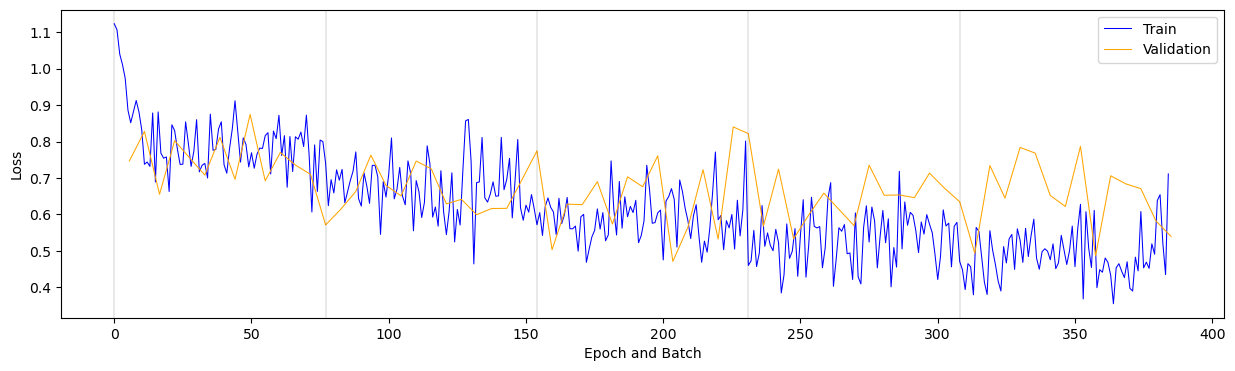

In [549]:
matplotlib.rc('figure', figsize=(15,4))
val_ticks = [(i+1)*len(losses['train'])/len(losses['val']) for i in range(len(losses['val']))]
plt.plot(range(len(losses['train'])), losses['train'], c='blue', lw=0.75)
plt.plot(val_ticks, losses['val'], c='orange', lw=0.75)
for i in range(num_epochs):
    plt.axvline(x=i*len(losses['train'])/num_epochs, c='black', lw=0.25, alpha=0.5)
plt.ylabel('Loss')
plt.xlabel('Epoch and Batch')
plt.legend(('Train','Validation'))

In [550]:
dataset.set_split('val')
len(dataset)

1350

In [551]:
# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)
y_true = []
y_pred = []

dataset.set_split('val')
with torch.no_grad():
    correct = 0
    total = 0
    for batch_data in dataloader:
        tweets = batch_data['x'].to(device)
        labels = batch_data['y'].to(device)
        outputs = model(tweets)
        _, predicted = torch.max(outputs.data, 1)
        y_true += labels.tolist()
        y_pred += predicted.tolist()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f"Accuracy (on {len(dataloader)*batch_size} validation tweets): {100 * correct / total:.2f}%")
	 

Accuracy (on 1400 validation tweets): 73.93%


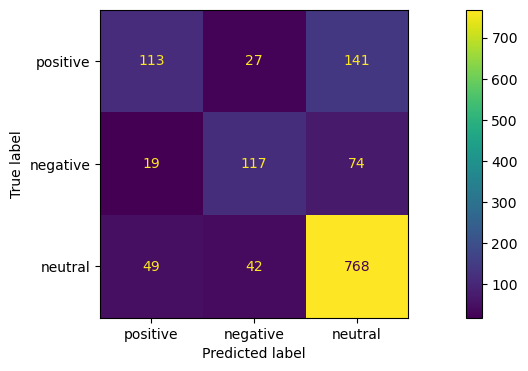

In [552]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=['positive','negative','neutral'])
disp.plot()

In [553]:
import torchsummary
torchsummary.summary(model, tuple(dataset[0]['x'].size()))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 128]         160,128
            Linear-2                   [-1, 32]           4,128
           Dropout-3                   [-1, 32]               0
            Linear-4                    [-1, 3]              99
Total params: 164,355
Trainable params: 164,355
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.63
Estimated Total Size (MB): 0.63
----------------------------------------------------------------


In [554]:
df_test['tokens_raw'] = df_test['text'].apply(lambda x: tokenizer(x.lower()))
X_test_int = df_test['tokens_raw'].apply(lambda x: stack_k_TweetEmbeddings(x)).values
X_test = torch.stack(tuple(X_test_int))
X_test.shape

torch.Size([1000, 1250])

In [555]:
y_test = torch.tensor([label_to_idx[lab] for lab in df_test['sentiment']])

In [556]:
test_dataset = AirlineTweetDataset(X_test, y_test)
test_dataset.create_split(len(X_test), seed=42, train_perc=1.0)

In [557]:
len(test_dataset)

1000

In [558]:
test_dataset[999]

{'x': tensor([0.2293, 0.3423, 0.0598,  ..., 0.0000, 0.0000, 0.0000]),
 'y': tensor(2)}

In [559]:
bs = 100
test_loader = DataLoader(dataset=test_dataset, batch_size=bs, shuffle=False)

In [560]:
y_true = []
y_pred = []
with torch.no_grad():
    correct = 0
    total = 0
    for batch_data in test_loader:
        tweets = batch_data['x'].to(device)
        labels = batch_data['y'].to(device)
        outputs = model(tweets)
        _, predicted = torch.max(outputs.data, 1)
        y_true += labels.tolist()
        y_pred += predicted.tolist()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f"Accuracy (on {len(test_loader)*bs} test tweets): {100 * correct / total:.2f}%")

Accuracy (on 1000 test tweets): 74.80%


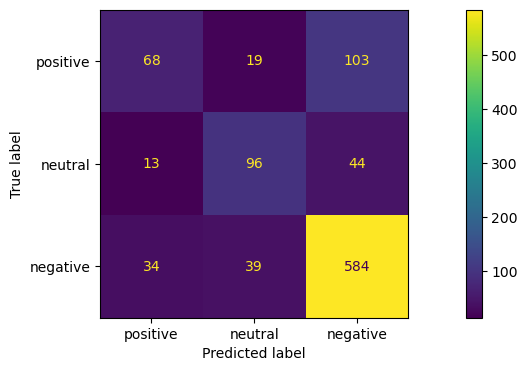

In [561]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=['positive','neutral','negative'])
disp.plot()